In [3]:
!pip install mplfinance
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


In [4]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv("traffic_dataset_with_trend.csv")
df

,Timestamp,Weather,Events,Traffic Volume
0,2023-01-01 00:00:00,Cloudy,False,803.0
1,2023-01-01 01:00:00,Clear,False,861.0
2,2023-01-01 02:00:00,Clear,False,582.0
3,2023-01-01 03:00:00,Cloudy,False,236.0
4,2023-01-01 04:00:00,Cloudy,False,569.0
...,...,...,...,...
8731,2023-12-30 19:00:00,Cloudy,False,1118.0
8732,2023-12-30 20:00:00,Clear,False,1681.0
8733,2023-12-30 21:00:00,Cloudy,False,833.0
8734,2023-12-30 22:00:00,Clear,False,740.0


In [6]:
df.shape

(8736, 4)

In [7]:
df.head()

,Timestamp,Weather,Events,Traffic Volume
0,2023-01-01 00:00:00,Cloudy,False,803.0
1,2023-01-01 01:00:00,Clear,False,861.0
2,2023-01-01 02:00:00,Clear,False,582.0
3,2023-01-01 03:00:00,Cloudy,False,236.0
4,2023-01-01 04:00:00,Cloudy,False,569.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       8736 non-null   object 
 1   Weather         8736 non-null   object 
 2   Events          8736 non-null   bool   
 3   Traffic Volume  8736 non-null   float64
dtypes: bool(1), float64(1), object(2)
memory usage: 213.4+ KB


In [9]:
df.isna().sum()

,0
Timestamp,0
Weather,0
Events,0
Traffic Volume,0


In [10]:
df.duplicated().sum()

0

In [11]:
df['Traffic Volume'].unique()

array([ 803.,  861.,  582., ..., 3627.,  506., 1967.])

In [12]:
df.columns

Index(['Timestamp', 'Weather', 'Events', 'Traffic Volume'], dtype='object')

In [13]:
df["Timestamp"] = pd.to_datetime(df.Timestamp)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       8736 non-null   datetime64[ns]
 1   Weather         8736 non-null   object        
 2   Events          8736 non-null   bool          
 3   Traffic Volume  8736 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(1)
memory usage: 213.4+ KB


In [15]:
df["year"] = df['Timestamp'].dt.year

In [16]:
df["month"] = df['Timestamp'].dt.month

In [17]:
df["day"] = df['Timestamp'].dt.day

In [18]:
df["hour"] = df['Timestamp'].dt.hour

In [19]:
df["year"].max()

2023

In [20]:
df['Traffic Volume'].unique().min()

118.0

In [21]:
df

,Timestamp,Weather,Events,Traffic Volume,year,month,day,hour
0,2023-01-01 00:00:00,Cloudy,False,803.0,2023,1,1,0
1,2023-01-01 01:00:00,Clear,False,861.0,2023,1,1,1
2,2023-01-01 02:00:00,Clear,False,582.0,2023,1,1,2
3,2023-01-01 03:00:00,Cloudy,False,236.0,2023,1,1,3
4,2023-01-01 04:00:00,Cloudy,False,569.0,2023,1,1,4
...,...,...,...,...,...,...,...,...
8731,2023-12-30 19:00:00,Cloudy,False,1118.0,2023,12,30,19
8732,2023-12-30 20:00:00,Clear,False,1681.0,2023,12,30,20
8733,2023-12-30 21:00:00,Cloudy,False,833.0,2023,12,30,21
8734,2023-12-30 22:00:00,Clear,False,740.0,2023,12,30,22


In [ ]:
#(df['two'] >= -0.5) & (df['two'] < 0.5)


In [22]:
df_specific = df[(df['Timestamp']>='2023-11-1')&(df['Timestamp']<='2023-11-30') & (df['Traffic Volume']> 118)]
df_specific

,Timestamp,Weather,Events,Traffic Volume,year,month,day,hour
7296,2023-11-01 00:00:00,Cloudy,True,2987.0,2023,11,1,0
7297,2023-11-01 01:00:00,Clear,False,1093.0,2023,11,1,1
7298,2023-11-01 02:00:00,Clear,False,1102.0,2023,11,1,2
7299,2023-11-01 03:00:00,Clear,False,1070.0,2023,11,1,3
7300,2023-11-01 04:00:00,Clear,False,1055.0,2023,11,1,4
...,...,...,...,...,...,...,...,...
7988,2023-11-29 20:00:00,Clear,False,741.0,2023,11,29,20
7989,2023-11-29 21:00:00,Clear,True,1601.0,2023,11,29,21
7990,2023-11-29 22:00:00,Cloudy,False,1063.0,2023,11,29,22
7991,2023-11-29 23:00:00,Rain,False,942.0,2023,11,29,23


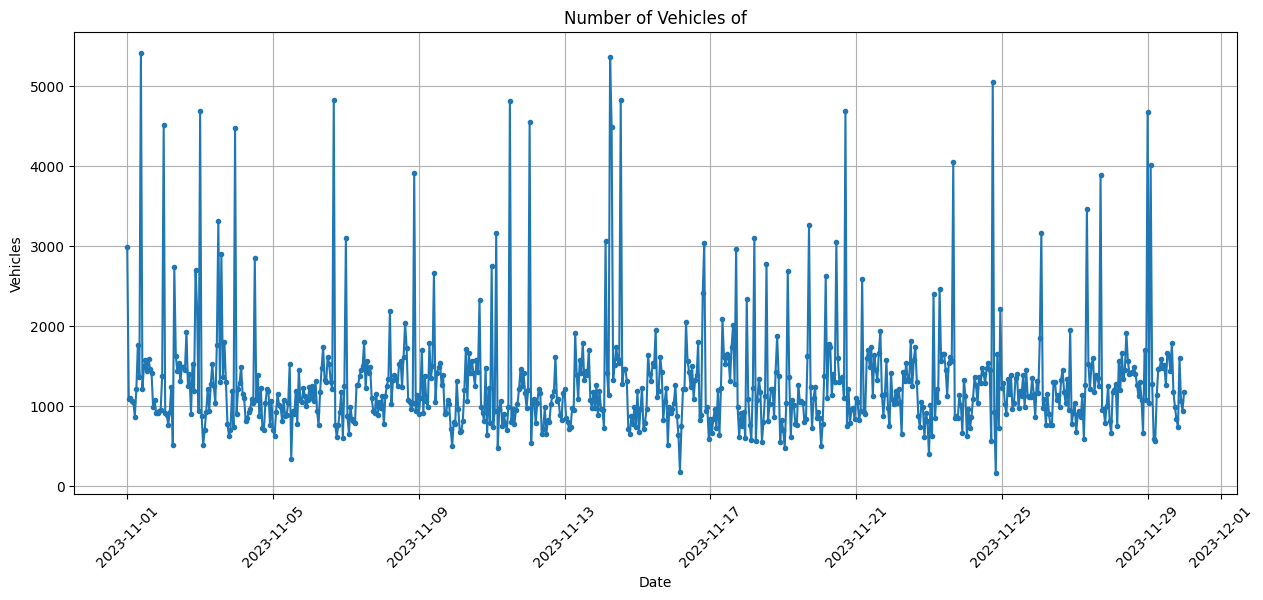

In [23]:

plt.figure(figsize=(15, 6))
plt.plot(df_specific['Timestamp'], df_specific['Traffic Volume'], marker='.')
plt.title('Number of Vehicles of')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

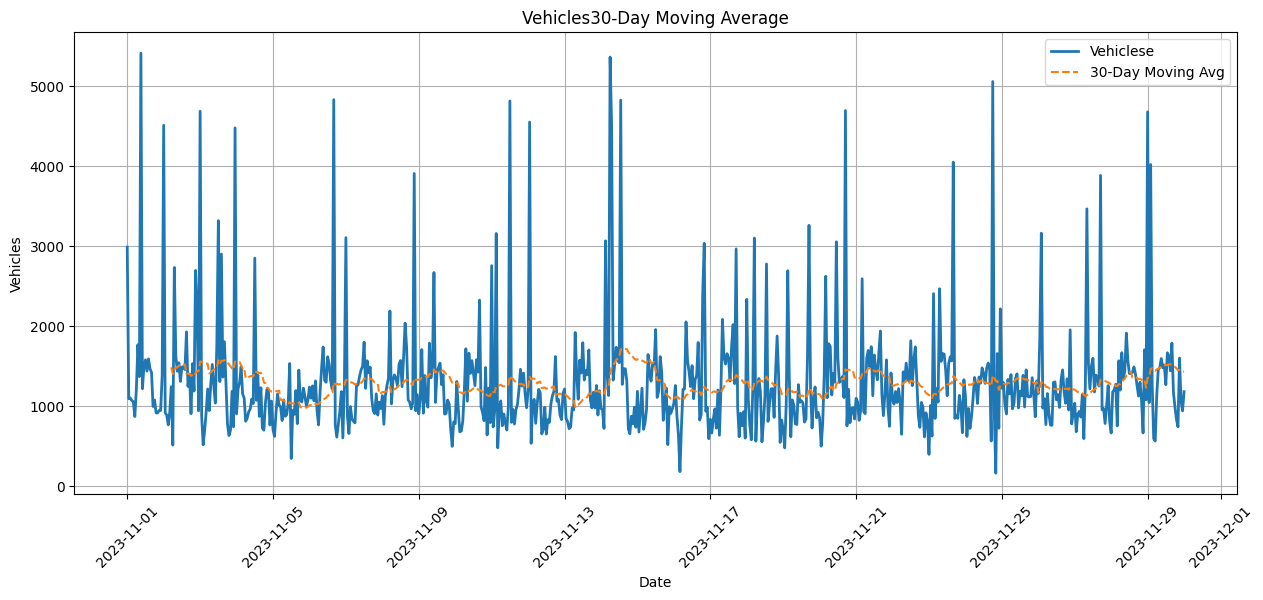

In [24]:

window = 30
plt.figure(figsize=(15, 6))
plt.plot(df_specific['Timestamp'], df_specific['Traffic Volume'], label='Vehiclese', linewidth=2)
plt.plot(df_specific['Timestamp'], df_specific['Traffic Volume'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Vehicles{window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Vehicles')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [25]:
df['Traffic Volume'].max()

6465.0

In [26]:

df_specific1 = df[(df['Weather'] == 'Cloudy') & (df['Traffic Volume'] > 100)& (df['Traffic Volume'] <2000)]
df_specific1

,Timestamp,Weather,Events,Traffic Volume,year,month,day,hour
0,2023-01-01 00:00:00,Cloudy,False,803.0,2023,1,1,0
3,2023-01-01 03:00:00,Cloudy,False,236.0,2023,1,1,3
4,2023-01-01 04:00:00,Cloudy,False,569.0,2023,1,1,4
7,2023-01-01 07:00:00,Cloudy,False,806.0,2023,1,1,7
9,2023-01-01 09:00:00,Cloudy,False,1062.0,2023,1,1,9
...,...,...,...,...,...,...,...,...
8722,2023-12-30 10:00:00,Cloudy,False,1200.0,2023,12,30,10
8725,2023-12-30 13:00:00,Cloudy,False,986.0,2023,12,30,13
8726,2023-12-30 14:00:00,Cloudy,False,761.0,2023,12,30,14
8731,2023-12-30 19:00:00,Cloudy,False,1118.0,2023,12,30,19


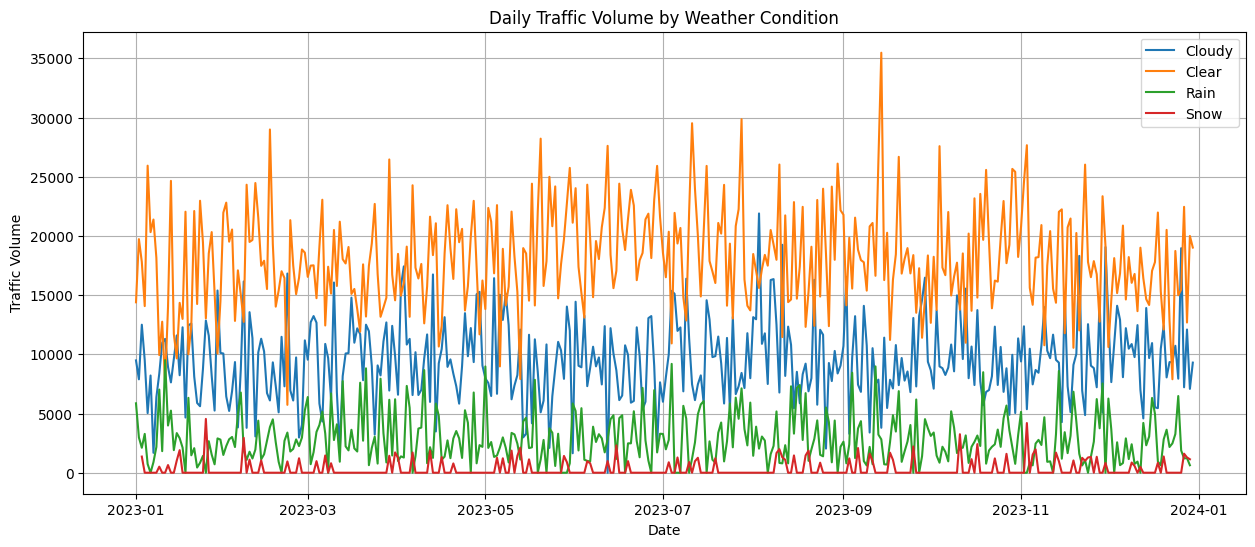

In [27]:

data = df[['Timestamp', 'Traffic Volume', 'Weather']]

data['Timestamp'] = pd.to_datetime(data['Timestamp'])

data.set_index('Timestamp', inplace=True)

daily_data = data.groupby('Weather')['Traffic Volume'].resample('D').sum()

plt.figure(figsize=(15, 6))
for weather in data['Weather'].unique():
  plt.plot(daily_data[weather], label=weather)

plt.title('Daily Traffic Volume by Weather Condition')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
daily_data

Weather  Timestamp 
Clear    2023-01-01    14396.0
         2023-01-02    19730.0
         2023-01-03    17810.0
         2023-01-04    14074.0
         2023-01-05    25936.0
                        ...   
Snow     2023-12-25        0.0
         2023-12-26        0.0
         2023-12-27     1607.0
         2023-12-28     1292.0
         2023-12-29     1137.0
Name: Traffic Volume, Length: 1452, dtype: float64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8736 entries, 0 to 8735
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       8736 non-null   datetime64[ns]
 1   Weather         8736 non-null   object        
 2   Events          8736 non-null   bool          
 3   Traffic Volume  8736 non-null   float64       
 4   year            8736 non-null   int32         
 5   month           8736 non-null   int32         
 6   day             8736 non-null   int32         
 7   hour            8736 non-null   int32         
dtypes: bool(1), datetime64[ns](1), float64(1), int32(4), object(1)
memory usage: 349.9+ KB


<Axes: xlabel='Weather'>

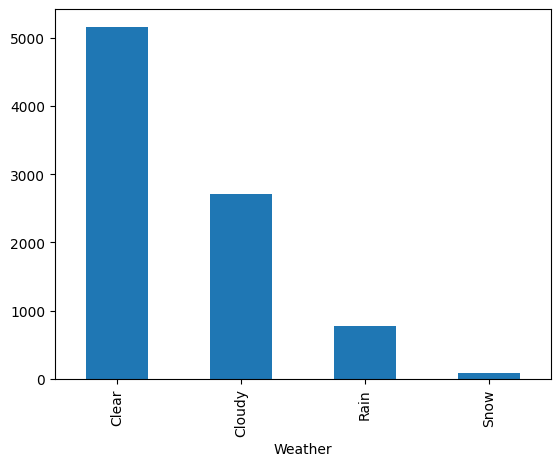

In [30]:
df['Weather'].value_counts().plot(kind='bar')

In [31]:
df.describe()

,Timestamp,Traffic Volume,year,month,day,hour
count,8736,8736.000000,8736.0,8736.000000,8736.000000,8736.000000
mean,2023-07-01 23:30:00,1281.395833,2023.0,6.510989,15.678571,11.500000
min,2023-01-01 00:00:00,118.000000,2023.0,1.000000,1.000000,0.000000
25%,2023-04-01 23:45:00,893.000000,2023.0,4.000000,8.000000,5.750000
50%,2023-07-01 23:30:00,1123.000000,2023.0,7.000000,16.000000,11.500000
75%,2023-09-30 23:15:00,1415.000000,2023.0,9.250000,23.000000,17.250000
max,2023-12-30 23:00:00,6465.000000,2023.0,12.000000,31.000000,23.000000
std,NaN,727.291462,0.0,3.440806,8.772240,6.922583


<Axes: ylabel='Frequency'>

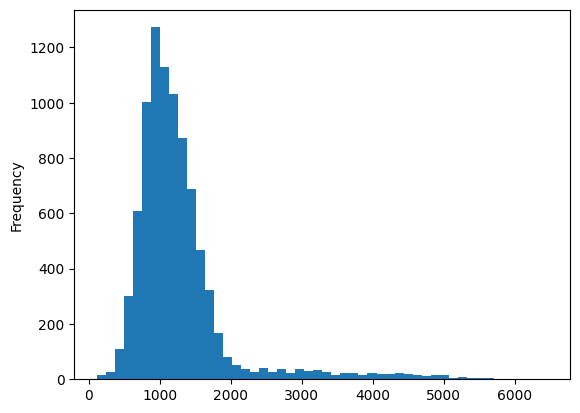

In [32]:
df['Traffic Volume'].plot(kind='hist',bins = 50)

<Axes: >

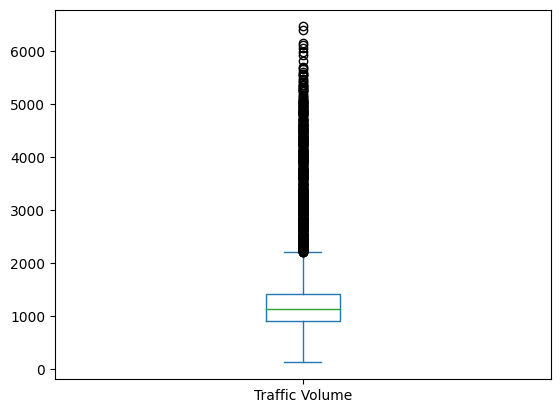

In [33]:
df['Traffic Volume'].plot(kind='box')

In [34]:
def remove_outliers(df,column):
    q1 = df[column].quantile(0.30)
    q3 = df[column].quantile(0.70)
    iqr = q3 - q1
    lower_bound  = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df.loc[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [35]:
df = remove_outliers(df,'Traffic Volume')

In [36]:
df.shape

(8040, 8)

<Axes: >

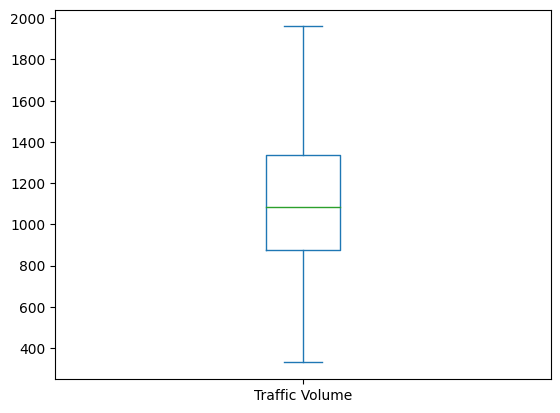

In [37]:
df['Traffic Volume'].plot(kind='box')

In [38]:
data = df_specific['Traffic Volume'].values.reshape(-1, 1)

In [39]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [40]:
train_size = int(len(data_normalized) * 0.8)
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]


In [41]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [42]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(497, 60)
(497,)


Testing set size:-
(80, 60)
(80,)


(None, None)

In [43]:
#Reshape input data for RNN([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [44]:
# Initialize a sequential model
model = Sequential()

# First RNN layer with 50 units, input shape, and return sequences
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second RNN layer with 50 units and return sequences
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 50 units
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])

In [55]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)  # Change file extension to '.keras'
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
history = model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - lo

<Axes: >

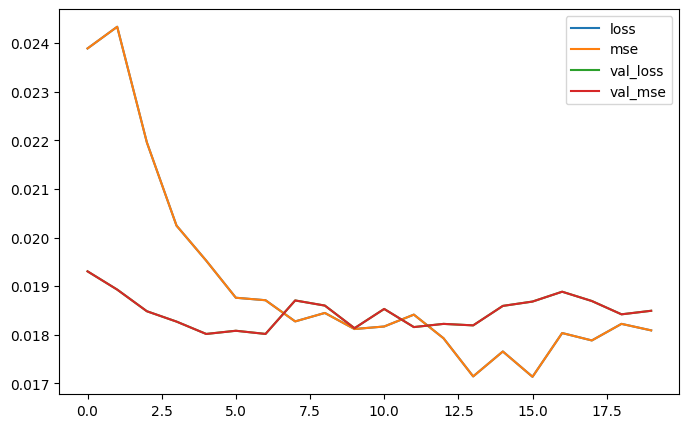

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))


In [57]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [58]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [59]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

1281.9173766957306
1293.5134191373234


<Axes: >

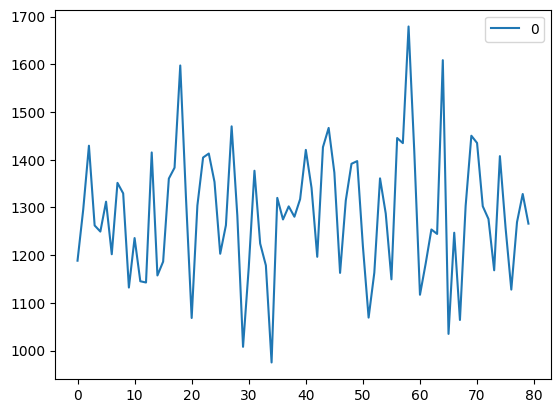

In [62]:
pd.DataFrame(test_predict).plot()

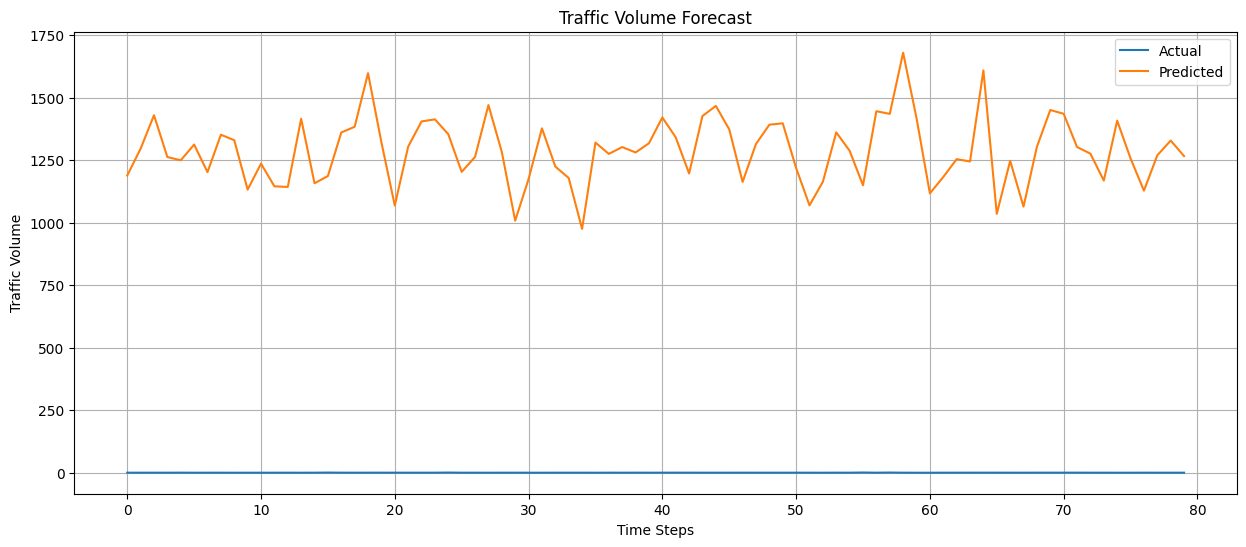

In [61]:
# Plot predictions vs actual values
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Traffic Volume Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()